<a href="https://colab.research.google.com/github/BobMcDear/Mercedes-Benz-Greener-Manufacturing/blob/main/benzGreener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from google.colab import files
from IPython.display import display

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
# To upload a Kaggle API token
files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions download -c mercedes-benz-greener-manufacturing
!unzip train.csv.zip
!unzip test.csv.zip

### Basic Data Pre-processing

In [ ]:
# The training data
train_raw = pd.read_csv('train.csv', low_memory=False)
# The test set, which we should submit to Kaggle
test_raw = pd.read_csv('test.csv', low_memory=False)
# For now, we'll drop the IDs but later we might use them
train_id = train_raw['ID']
train_raw.drop('ID', axis=1, inplace=True)
test_id = test_raw['ID']
test_raw.drop('ID', axis=1, inplace=True)

In [ ]:
def display_df(df, n=5):
  display(df.head(n))
  display(df.tail(n))

In [ ]:
display_df(train_raw)

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
4204,107.39,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,108.77,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,109.22,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,87.48,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4208,110.85,z,r,ae,c,d,aa,g,w,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
display_df(test_raw)

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,az,v,as,f,d,a,j,j,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,az,l,n,f,d,z,l,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,w,s,as,c,d,y,i,m,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
4204,aj,h,as,f,d,aa,j,e,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4205,t,aa,ai,d,d,aa,j,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,y,v,as,f,d,aa,d,w,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4207,ak,v,as,a,d,aa,c,q,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4208,t,aa,ai,c,d,aa,g,r,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
train_raw.isna().sum().sum(), test_raw.isna().sum().sum()

(0, 0)

In [ ]:
dep_var = 'y'
# According to Kaggle, the categorical features in
# this dataset are the ones with strings, which are the following
cat_names = ['X0', 'X1', 'X2', 'X3',
             'X4', 'X5', 'X6', 'X8']

In [ ]:
df = train_raw.append(test_raw)
# We can't see the changes here (if we display the DataFrame,
# df[cat_names] still has strings) but behind the scenes, there's
# numbers assigned to df[cat_names]
df[cat_names] = df[cat_names].astype('category')
for cat_name in cat_names:
  # Replaces df[cat_name] with the numbers assigned to it
  df[cat_name] = df[cat_name].cat.codes
train, test = df.iloc[:len(train_raw)], df.iloc[len(train_raw):]
test.drop(dep_var, axis=1, inplace=True)

In [ ]:
display_df(train)

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,37,23,20,0,3,27,9,14,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,37,21,22,4,3,31,11,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,24,24,38,2,3,30,9,23,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,24,21,38,5,3,30,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,24,23,38,5,3,14,3,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
4204,107.39,10,20,19,2,3,1,3,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,108.77,36,16,44,3,3,1,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,109.22,10,23,42,0,3,1,6,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,87.48,11,19,29,5,3,1,11,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4208,110.85,52,19,5,2,3,1,6,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
display_df(test)

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,24,23,38,5,3,26,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,46,3,9,0,3,9,6,24,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,24,23,19,5,3,0,9,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,24,13,38,5,3,32,11,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,49,20,19,2,3,31,8,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
4204,9,9,19,5,3,1,9,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4205,46,1,9,3,3,1,9,24,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,51,23,19,5,3,1,3,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4207,10,23,19,0,3,1,2,16,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4208,46,1,9,2,3,1,6,17,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Validation, Fine-tuning, and Feature Selection

In [ ]:
def split_valid(a, n_valid=0.2):
  # If n_valid is a percentage, calculate how many rows
  # it translates into
  if 0<n_valid<1: n_valid = int(n_valid*len(a))
  # (Rows up to but not including len(a)-n_valid,
  # rows from len(a)-n_valid)
  return a.iloc[:-n_valid], a.iloc[-n_valid:]

In [ ]:
def fit_validate(m, df, n_valid=0.2):
  X = df.drop(dep_var, axis=1)
  y = df[dep_var]
  X_train, X_valid = split_valid(X, n_valid)
  y_train, y_valid = split_valid(y, n_valid)
  m.fit(X_train, y_train)
  # The metric used in this competition is R2,
  # which is calculated via m.score() in Scikit-learn regressors
  score = m.score(X_valid, y_valid)
  return score

In [ ]:
def cross_validation(m, df, k=100, n_valid=0.2):
  scores = []
  for _ in range(k):
      # Shuffle the dataset
      df = df.sample(frac=1)
      curr_score = fit_validate(m, df, n_valid)
      scores.append(curr_score)
  scores = np.array(scores)
  return scores

In [ ]:
def print_cross_val(m_type, df, k=100, n_valid=0.2,
                 **kwargs):
  # Create an m_type with kwargs as hyperparameters
  m = m_type(**kwargs)
  scores = cross_validation(m, df, k=k, n_valid=n_valid)
  print(f'Cross validation scores: {scores}')
  print(f'Cross validation average score: {scores.mean()}')
  print(f'Cross validation standard deviation: {scores.std()}')

In [ ]:
from functools import partial

In [ ]:
rf_cross_val = partial(print_cross_val, RandomForestRegressor, 
                       train, k=100, n_valid=0.2, n_jobs=-1, n_estimators=40)

In [ ]:
rf_cross_val()

In [ ]:
rf_cross_val(min_samples_leaf=3)

In [ ]:
rf_cross_val(min_samples_leaf=5)

In [ ]:
rf_cross_val(min_samples_leaf=10)

In [ ]:
rf_cross_val(min_samples_leaf=25)

In [ ]:
rf_cross_val(min_samples_leaf=100)

In [ ]:
rf_cross_val(min_samples_leaf=25, max_features=0.5)

In [ ]:
rf_args = {'n_jobs': -1,
           'n_estimators': 40,
           'min_samples_leaf': 25}
rf = RandomForestRegressor(**rf_args)

In [ ]:
X = train.drop(dep_var, axis=1)
y = train[dep_var]
rf.fit(X, y)

In [ ]:
def create_feat_imp(rf, x):
  feat_imp = pd.DataFrame({'cols': x.columns,
                           'imps': rf.feature_importances_}
                          ).sort_values('imps', ascending=False)
  return feat_imp

In [ ]:
def plot_feat_imp(feat_imp):
  # Display the 10 most and least important features
  display_df(feat_imp, 10)
  # Plot the 10 most important features and their respective importances
  feat_imp[:10].plot('cols', 'imps', 'barh')

In [ ]:
feat_imp = create_feat_imp(rf, X)

In [ ]:
plot_feat_imp(feat_imp)

In [ ]:
to_keep = list(feat_imp[0.01<=feat_imp['imps']]['cols'])
train_keep = train[to_keep+[dep_var]]

In [ ]:
print_cross_val(RandomForestRegressor, train_keep, 
             **rf_args)

Cross validation scores: [0.483933   0.6055444  0.62954818 0.50810058 0.5885873  0.54310625
 0.60377287 0.63347228 0.47210482 0.58007404 0.5724194  0.53876901
 0.45741914 0.5572044  0.52661497 0.57060411 0.56329486 0.56252358
 0.41828812 0.56232873 0.60171548 0.62463992 0.57819125 0.550851
 0.57447535 0.60023339 0.57278238 0.59217766 0.61712763 0.49888787
 0.58644391 0.61494562 0.61170315 0.48682689 0.48429448 0.62017648
 0.56780349 0.59329312 0.55566617 0.6050747  0.59683027 0.5990909
 0.56192914 0.46354799 0.5596823  0.58771912 0.59300416 0.59750945
 0.45277343 0.46928186 0.57292302 0.63640178 0.47467714 0.60144341
 0.56683455 0.47623775 0.63735025 0.59441329 0.49000619 0.64874205
 0.56391905 0.43777686 0.59373646 0.6096481  0.44283283 0.60025644
 0.63499626 0.49708081 0.40455648 0.60974075 0.57931627 0.56851729
 0.63906566 0.58018637 0.54315595 0.5484312  0.57535499 0.56003874
 0.45068845 0.49969006 0.46882462 0.58504126 0.46695994 0.57405365
 0.57329441 0.51652152 0.55446918 0.4953

In [ ]:
train = train[to_keep+[dep_var]]
X = X[to_keep]

In [ ]:
rf.fit(X, y)
feat_imp = create_feat_imp(rf, X)

In [ ]:
plot_feat_imp(feat_imp)

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc

In [ ]:
corr = np.round(scipy.stats.spearmanr(train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
(train['X232'] != train['X279']).sum(), (train['X232'] != train['X29']).sum(), (test['X232'] != test['X279']).sum(), (test['X232'] != test['X29']).sum()

In [ ]:
(train['X118'] != train['X119']).sum(), (test['X118'] != test['X119']).sum()

In [ ]:
train.drop(['X279', 'X29', 'X118'], axis=1, inplace=True)
X.drop(['X279', 'X29', 'X118'], axis=1, inplace=True)

In [ ]:
# Must redefine rf_cross_val since we changed our dataset
rf_cross_val = partial(print_cross_val, RandomForestRegressor, 
                       train, k=100, n_valid=0.2, n_jobs=-1, n_estimators=40)
rf_cross_val(min_samples_leaf=25)

### Exploratory Data Analysis

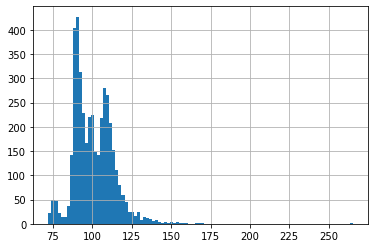

In [ ]:
train_raw[dep_var].hist(bins=100)

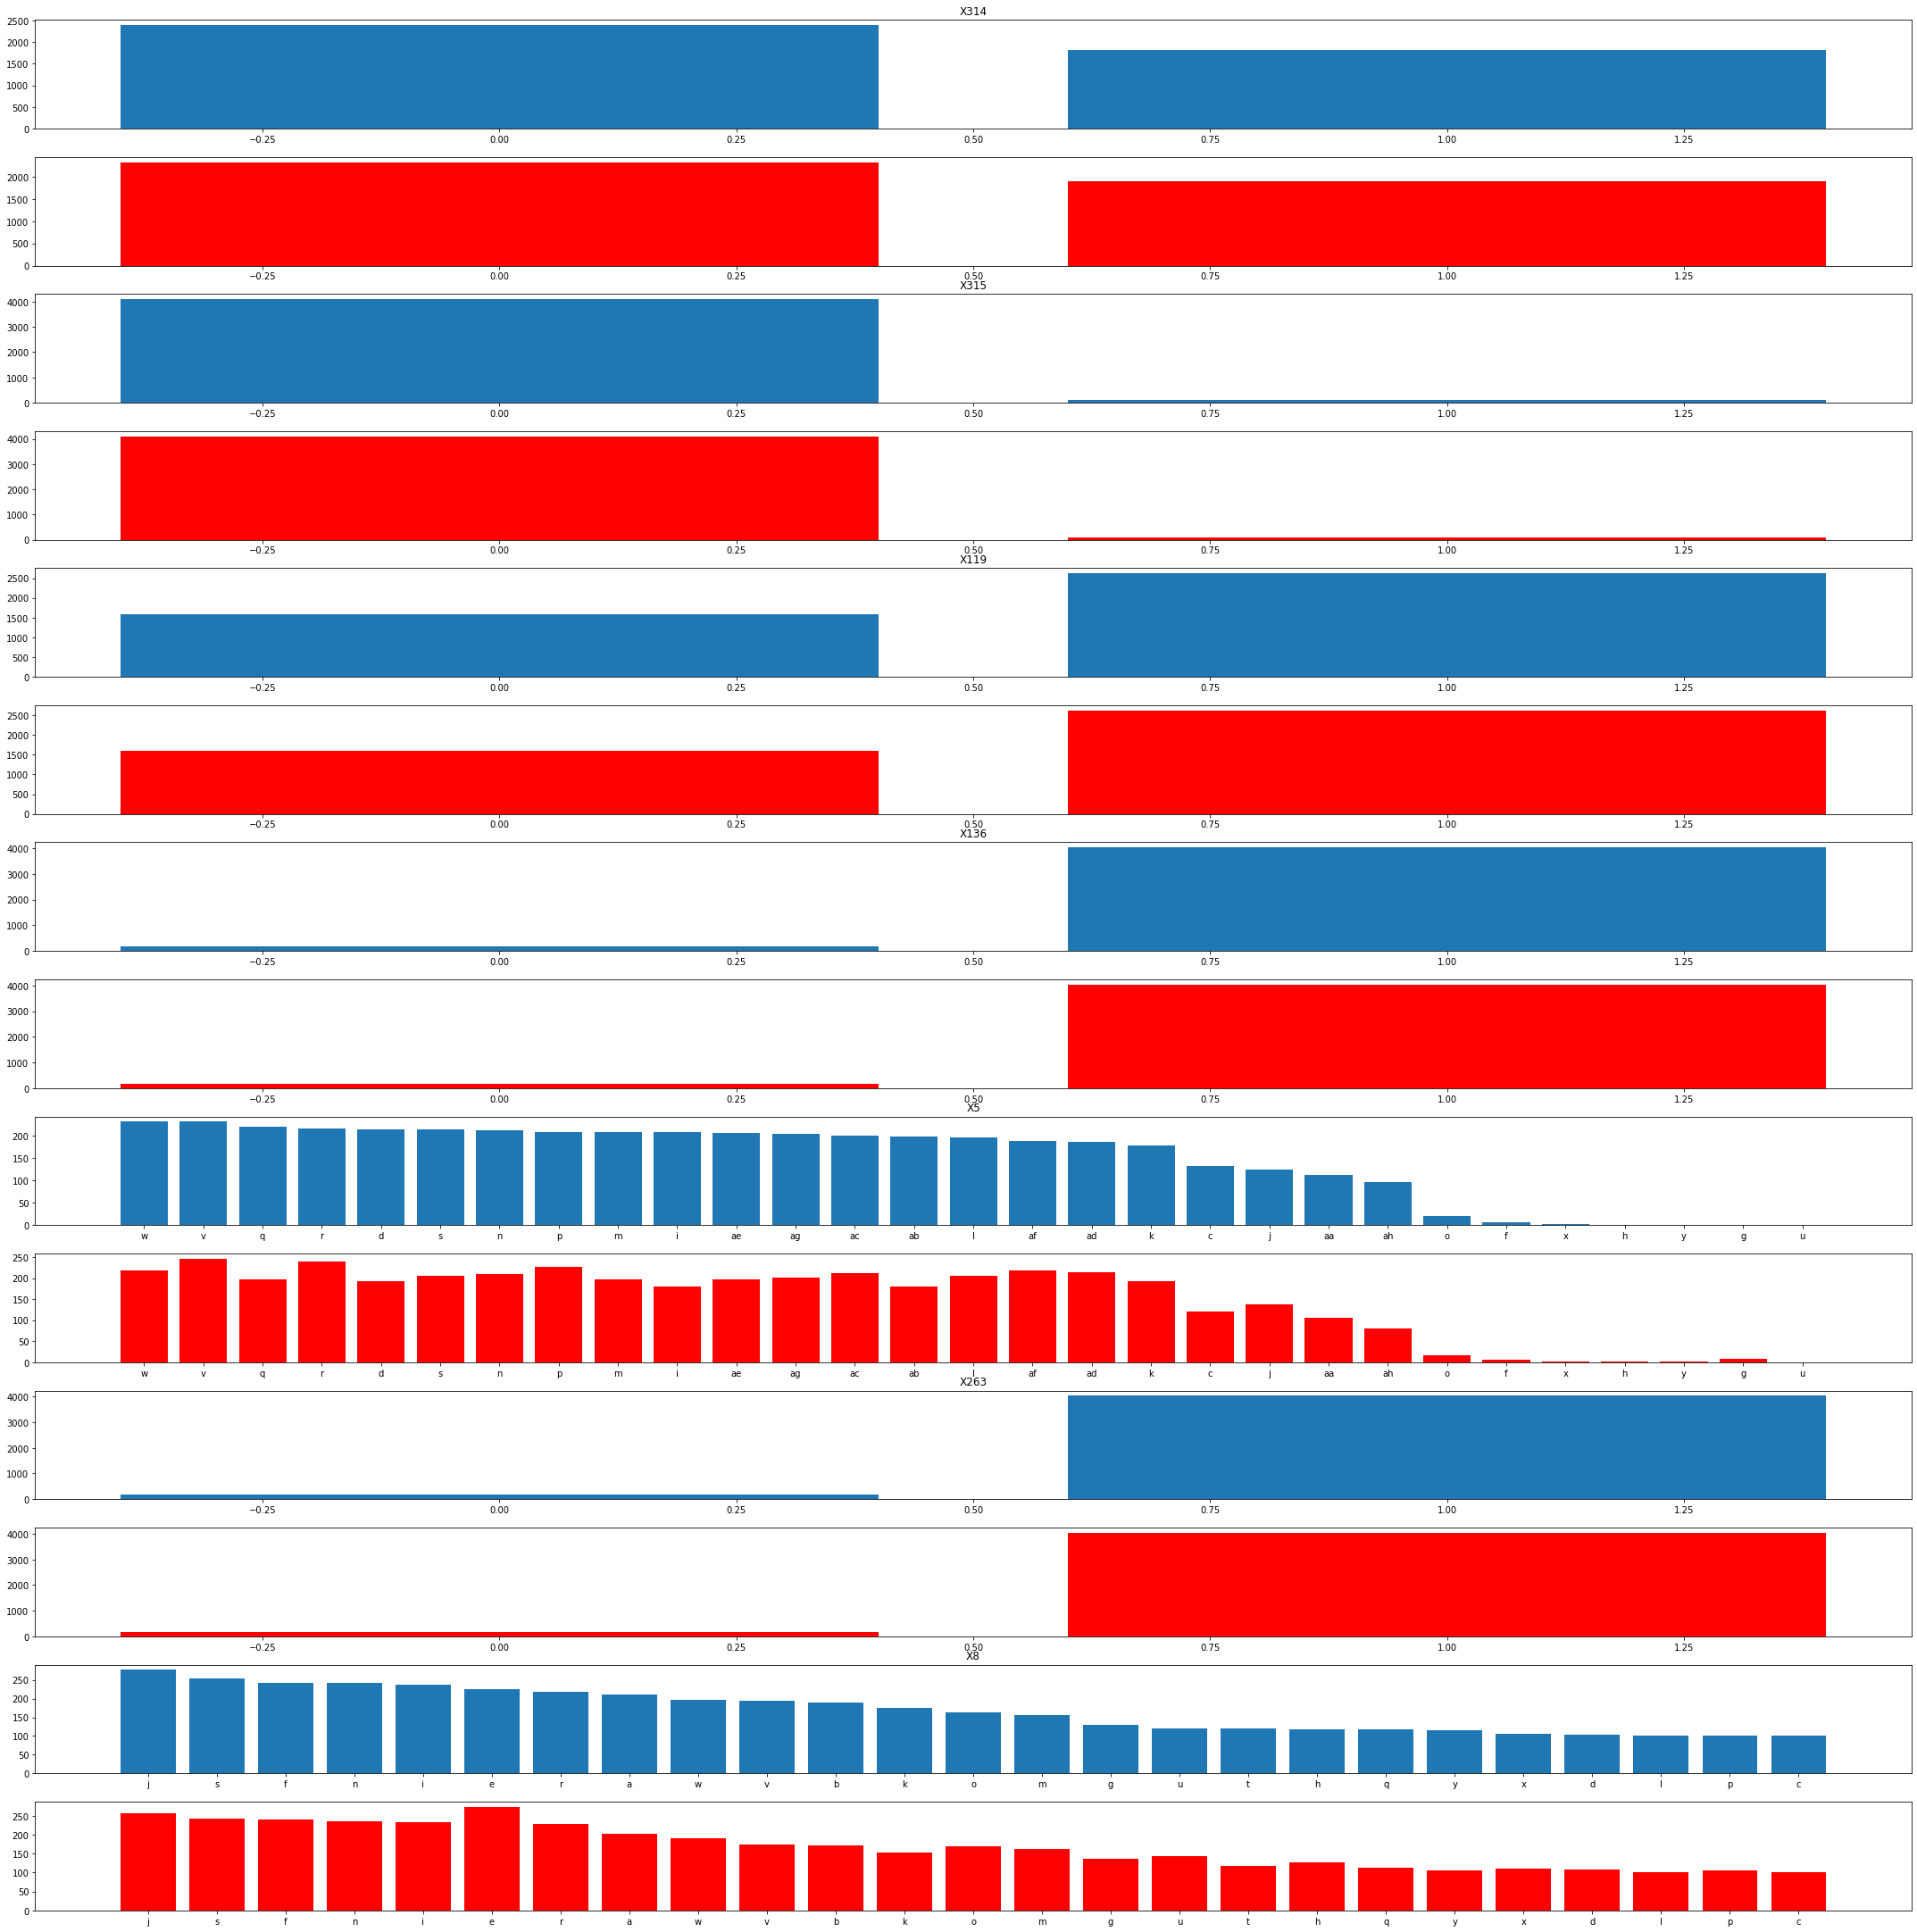

In [ ]:
# Create a subplot for each of our columns for each dataset
fig, axs = plt.subplots(2*(train.shape[1]-1), figsize=(30, 30))
# More space between the plots
fig.tight_layout()
for i, feat in enumerate(train.columns):
  if feat == dep_var: continue
  # This is a Series whose index is each class in our column
  # and whose values are the number of occurences of each class
  val_counts = train_raw[feat].value_counts()
  # Our classes
  indx = val_counts.index
  # The frequency of each class
  occ = val_counts.values
  # Draw the plot for the training set
  axs[2*i].bar(indx, occ)
  axs[2*i].set_title(feat)
  # Same as val_counts but for the test set
  val_counts = test_raw[feat].value_counts()
  # Set the occurences of classes that appear in
  # the training set but not in the test set to 0
  for j in indx:
    if j not in val_counts.index: val_counts[j] = 0
  # Modify the Series so that for categorical features, the ith index
  # in val_counts corresponds to the same category as the ith index
  # in val_counts for the training set
  val_counts = pd.Series([val_counts[i] for i in indx], index=indx)
  occ = val_counts.values
  axs[2*i+1].bar(indx, occ, color='red')

In [ ]:
for col in train.columns:
  if col == dep_var: continue
  # Since we're just interested in the dependent variable,
  # only include that
  # This basically includes 2 bags for binary features
  # and about 25 bags (number of classes) for our categorical
  # features
  g = train_raw[[col, dep_var]].groupby(col)
  # Print .describe() on each separate bag
  # instead of the entire df
  display(g.describe())

y                                                              
       count        mean        std    min     25%     50%     75%     max
X314                                                                      
0     2392.0   93.973253  10.800766  72.11   88.87   91.54   96.51  265.32
1     1817.0  109.484392   9.062277  92.97  103.91  108.54  112.80  165.52

y                                                                  
       count        mean        std     min       25%      50%     75%     max
X315                                                                          
0     4088.0  100.254883  12.534602   72.11   90.7075   98.655  108.68  265.32
1      121.0  114.671074   9.104976  100.63  109.2800  112.510  116.75  169.91

y                                                                
       count        mean        std    min     25%     50%       75%     max
X119                                                                        
0     1590.0   96.231748  12.076425  72.11  89.410   96.13  101.5875  265.32
1     2619.0  103.363375  12.274670  83.96  91.775  105.43  111.0800  167.45

y                                                               
       count        mean        std    min      25%    50%      75%     max
X136                                                                       
0      183.0   78.775847   9.186293  72.11  75.0200  76.84   79.155  169.91
1     4026.0  101.664476  11.894404  82.62  91.4725  99.91  109.310  265.32

y                                                                
       count        mean        std    min      25%    50%       75%     max
X263                                                                        
0      181.0   77.964862   4.616847  72.11  74.9900  76.81   79.0300  104.65
1     4028.0  101.689553  11.951113  82.62  91.4775  99.92  109.3225  265.32

y                                                                    
    count        mean        std     min       25%      50%       75%     max
X5                                                                           
aa  112.0   98.672500  11.809663   73.25   89.0125   97.415  106.6550  149.52
ab  197.0  102.503655  13.614693   73.59   91.3800  100.810  110.2100  160.87
ac  200.0   99.901800  12.929024   73.15   90.6775   98.155  108.3900  167.45
ad  185.0  101.493189  12.550206   72.11   91.1100  101.130  110.4700  133.50
ae  205.0  100.878341  11.717659   72.94   91.4300   99.670  109.4400  139.61
af  188.0  101.246968  11.663406   76.27   91.3800  100.680  110.5000  140.49
ag  204.0  102.920147  17.539515   76.22   91.4600   99.750  108.6575  265.32
ah   97.0   98.853505  12.125668   72.50   90.2600   97.770  107.4000  132.61
c   131.0  102.343130  13.064378   73.40   91.6900  101.470  111.7700  147.72
d   214.0  100.631402  11.677963   73.34   91.4700   99.495  108.9100  154.87
f     7.0  105.594286  17.258377   82.62   95.0150  102.090  117.8300  128.76
g     1.0   92.930000        NaN   92.93   92.9300   92.930   92.9300   92.93
h     1.0   78.020000        NaN   78.02   78.0200   78.020   78.0200   78.02
i   207.0  100.994010  13.194197   74.00   90.5400   99.050  108.9200  169.91
j   125.0  100.931360  11.759058   73.70   91.5700   98.910  110.0200  139.20
k   177.0  100.082373  12.126843   73.79   91.3100   98.120  108.7100  154.16
l   195.0   99.657436  11.003991   74.20   90.8750   98.830  109.2100  126.97
m   208.0  101.768317  12.926739   73.71   91.3475  100.625  109.8050  158.23
n   212.0  102.594104  14.380612   74.43   90.8075  100.145  111.6650  148.94
o    20.0   96.107500   8.833043   85.09   88.9575   93.680  101.0025  112.97
p   208.0  100.859471  12.810197   73.02   91.1725   99.045  108.8325  147.22
q   220.0  100.754273  13.038478   73.52   91.3925   98.365  108.3525  165.52
r   215.0   98.705395  11.101177   73.24   90.2100   97.740  107.8900  139.07
s   214.0  100.285888  11.247534   74.22   90.7125  100.020  108.9200  141.09
u     1.0  130.810000        NaN  130.81  130.8100  130.810  130.8100  130.81
v   231.0   99.782987  11.612251   75.38   90.3700   98.160  107.8450  155.62
w   231.0   98.707100  11.825705   73.36   89.0500   98.010  107.8650  142.46
x     2.0   78.440000   3.082986   76.26   77.3500   78.440   79.5300   80.62
y     1.0   88.530000        NaN   88.53   88.5300   88.530   88.5300   88.53

y                                                                
       count        mean        std    min     25%     50%       75%     max
X127                                                                        
0     2125.0  107.080136  12.561987  72.11  101.64  108.25  112.5700  169.91
1     2084.0   94.132375   8.898652  82.62   89.28   91.63   95.6625  265.32

y                                                                
       count        mean        std    min      25%    50%       75%     max
X232                                                                        
0     4028.0  101.689553  11.951113  82.62  91.4775  99.92  109.3225  265.32
1      181.0   77.964862   4.616847  72.11  74.9900  76.81   79.0300  104.65

In [ ]:
(train['X136'] != train['X263']).sum(), (train['X136'] == train['X232']).sum(), (test['X136'] != test['X263']).sum(), (test['X136'] == test['X232']).sum()

(2, 2, 0, 0)

In [ ]:
train.drop(['X136', 'X263'], axis=1, inplace=True)
X.drop(['X136', 'X263'], axis=1, inplace=True)

In [ ]:
rf_cross_val(min_samples_leaf=25)

In [ ]:
g = train_raw[['X5', dep_var]].groupby('X5')
des = g.describe()
display(des.sort_values(('y', 'mean')))
display(des.sort_values(('y', 'count')))
# Since the indices are the classes, 
# we're effectively sorting by classes
display(des.sort_index())

y                                                                    
    count        mean        std     min       25%      50%       75%     max
X5                                                                           
h     1.0   78.020000        NaN   78.02   78.0200   78.020   78.0200   78.02
x     2.0   78.440000   3.082986   76.26   77.3500   78.440   79.5300   80.62
y     1.0   88.530000        NaN   88.53   88.5300   88.530   88.5300   88.53
g     1.0   92.930000        NaN   92.93   92.9300   92.930   92.9300   92.93
o    20.0   96.107500   8.833043   85.09   88.9575   93.680  101.0025  112.97
aa  112.0   98.672500  11.809663   73.25   89.0125   97.415  106.6550  149.52
r   215.0   98.705395  11.101177   73.24   90.2100   97.740  107.8900  139.07
w   231.0   98.707100  11.825705   73.36   89.0500   98.010  107.8650  142.46
ah   97.0   98.853505  12.125668   72.50   90.2600   97.770  107.4000  132.61
l   195.0   99.657436  11.003991   74.20   90.8750   98.830  109.2100  126.97
v   231.0   99.782987  11.612251   75.38   90.3700   98.160  107.8450  155.62
ac  200.0   99.901800  12.929024   73.15   90.6775   98.155  108.3900  167.45
k   177.0  100.082373  12.126843   73.79   91.3100   98.120  108.7100  154.16
s   214.0  100.285888  11.247534   74.22   90.7125  100.020  108.9200  141.09
d   214.0  100.631402  11.677963   73.34   91.4700   99.495  108.9100  154.87
q   220.0  100.754273  13.038478   73.52   91.3925   98.365  108.3525  165.52
p   208.0  100.859471  12.810197   73.02   91.1725   99.045  108.8325  147.22
ae  205.0  100.878341  11.717659   72.94   91.4300   99.670  109.4400  139.61
j   125.0  100.931360  11.759058   73.70   91.5700   98.910  110.0200  139.20
i   207.0  100.994010  13.194197   74.00   90.5400   99.050  108.9200  169.91
af  188.0  101.246968  11.663406   76.27   91.3800  100.680  110.5000  140.49
ad  185.0  101.493189  12.550206   72.11   91.1100  101.130  110.4700  133.50
m   208.0  101.768317  12.926739   73.71   91.3475  100.625  109.8050  158.23
c   131.0  102.343130  13.064378   73.40   91.6900  101.470  111.7700  147.72
ab  197.0  102.503655  13.614693   73.59   91.3800  100.810  110.2100  160.87
n   212.0  102.594104  14.380612   74.43   90.8075  100.145  111.6650  148.94
ag  204.0  102.920147  17.539515   76.22   91.4600   99.750  108.6575  265.32
f     7.0  105.594286  17.258377   82.62   95.0150  102.090  117.8300  128.76
u     1.0  130.810000        NaN  130.81  130.8100  130.810  130.8100  130.81

y                                                                    
    count        mean        std     min       25%      50%       75%     max
X5                                                                           
y     1.0   88.530000        NaN   88.53   88.5300   88.530   88.5300   88.53
u     1.0  130.810000        NaN  130.81  130.8100  130.810  130.8100  130.81
h     1.0   78.020000        NaN   78.02   78.0200   78.020   78.0200   78.02
g     1.0   92.930000        NaN   92.93   92.9300   92.930   92.9300   92.93
x     2.0   78.440000   3.082986   76.26   77.3500   78.440   79.5300   80.62
f     7.0  105.594286  17.258377   82.62   95.0150  102.090  117.8300  128.76
o    20.0   96.107500   8.833043   85.09   88.9575   93.680  101.0025  112.97
ah   97.0   98.853505  12.125668   72.50   90.2600   97.770  107.4000  132.61
aa  112.0   98.672500  11.809663   73.25   89.0125   97.415  106.6550  149.52
j   125.0  100.931360  11.759058   73.70   91.5700   98.910  110.0200  139.20
c   131.0  102.343130  13.064378   73.40   91.6900  101.470  111.7700  147.72
k   177.0  100.082373  12.126843   73.79   91.3100   98.120  108.7100  154.16
ad  185.0  101.493189  12.550206   72.11   91.1100  101.130  110.4700  133.50
af  188.0  101.246968  11.663406   76.27   91.3800  100.680  110.5000  140.49
l   195.0   99.657436  11.003991   74.20   90.8750   98.830  109.2100  126.97
ab  197.0  102.503655  13.614693   73.59   91.3800  100.810  110.2100  160.87
ac  200.0   99.901800  12.929024   73.15   90.6775   98.155  108.3900  167.45
ag  204.0  102.920147  17.539515   76.22   91.4600   99.750  108.6575  265.32
ae  205.0  100.878341  11.717659   72.94   91.4300   99.670  109.4400  139.61
i   207.0  100.994010  13.194197   74.00   90.5400   99.050  108.9200  169.91
m   208.0  101.768317  12.926739   73.71   91.3475  100.625  109.8050  158.23
p   208.0  100.859471  12.810197   73.02   91.1725   99.045  108.8325  147.22
n   212.0  102.594104  14.380612   74.43   90.8075  100.145  111.6650  148.94
s   214.0  100.285888  11.247534   74.22   90.7125  100.020  108.9200  141.09
d   214.0  100.631402  11.677963   73.34   91.4700   99.495  108.9100  154.87
r   215.0   98.705395  11.101177   73.24   90.2100   97.740  107.8900  139.07
q   220.0  100.754273  13.038478   73.52   91.3925   98.365  108.3525  165.52
v   231.0   99.782987  11.612251   75.38   90.3700   98.160  107.8450  155.62
w   231.0   98.707100  11.825705   73.36   89.0500   98.010  107.8650  142.46

y                                                                    
    count        mean        std     min       25%      50%       75%     max
X5                                                                           
aa  112.0   98.672500  11.809663   73.25   89.0125   97.415  106.6550  149.52
ab  197.0  102.503655  13.614693   73.59   91.3800  100.810  110.2100  160.87
ac  200.0   99.901800  12.929024   73.15   90.6775   98.155  108.3900  167.45
ad  185.0  101.493189  12.550206   72.11   91.1100  101.130  110.4700  133.50
ae  205.0  100.878341  11.717659   72.94   91.4300   99.670  109.4400  139.61
af  188.0  101.246968  11.663406   76.27   91.3800  100.680  110.5000  140.49
ag  204.0  102.920147  17.539515   76.22   91.4600   99.750  108.6575  265.32
ah   97.0   98.853505  12.125668   72.50   90.2600   97.770  107.4000  132.61
c   131.0  102.343130  13.064378   73.40   91.6900  101.470  111.7700  147.72
d   214.0  100.631402  11.677963   73.34   91.4700   99.495  108.9100  154.87
f     7.0  105.594286  17.258377   82.62   95.0150  102.090  117.8300  128.76
g     1.0   92.930000        NaN   92.93   92.9300   92.930   92.9300   92.93
h     1.0   78.020000        NaN   78.02   78.0200   78.020   78.0200   78.02
i   207.0  100.994010  13.194197   74.00   90.5400   99.050  108.9200  169.91
j   125.0  100.931360  11.759058   73.70   91.5700   98.910  110.0200  139.20
k   177.0  100.082373  12.126843   73.79   91.3100   98.120  108.7100  154.16
l   195.0   99.657436  11.003991   74.20   90.8750   98.830  109.2100  126.97
m   208.0  101.768317  12.926739   73.71   91.3475  100.625  109.8050  158.23
n   212.0  102.594104  14.380612   74.43   90.8075  100.145  111.6650  148.94
o    20.0   96.107500   8.833043   85.09   88.9575   93.680  101.0025  112.97
p   208.0  100.859471  12.810197   73.02   91.1725   99.045  108.8325  147.22
q   220.0  100.754273  13.038478   73.52   91.3925   98.365  108.3525  165.52
r   215.0   98.705395  11.101177   73.24   90.2100   97.740  107.8900  139.07
s   214.0  100.285888  11.247534   74.22   90.7125  100.020  108.9200  141.09
u     1.0  130.810000        NaN  130.81  130.8100  130.810  130.8100  130.81
v   231.0   99.782987  11.612251   75.38   90.3700   98.160  107.8450  155.62
w   231.0   98.707100  11.825705   73.36   89.0500   98.010  107.8650  142.46
x     2.0   78.440000   3.082986   76.26   77.3500   78.440   79.5300   80.62
y     1.0   88.530000        NaN   88.53   88.5300   88.530   88.5300   88.53

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb20e5cac88>]],
      dtype=object)

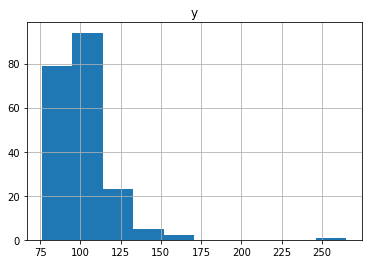

In [ ]:
train_raw[['X5', dep_var]].loc[train_raw['X5'] == 'ag'].hist()

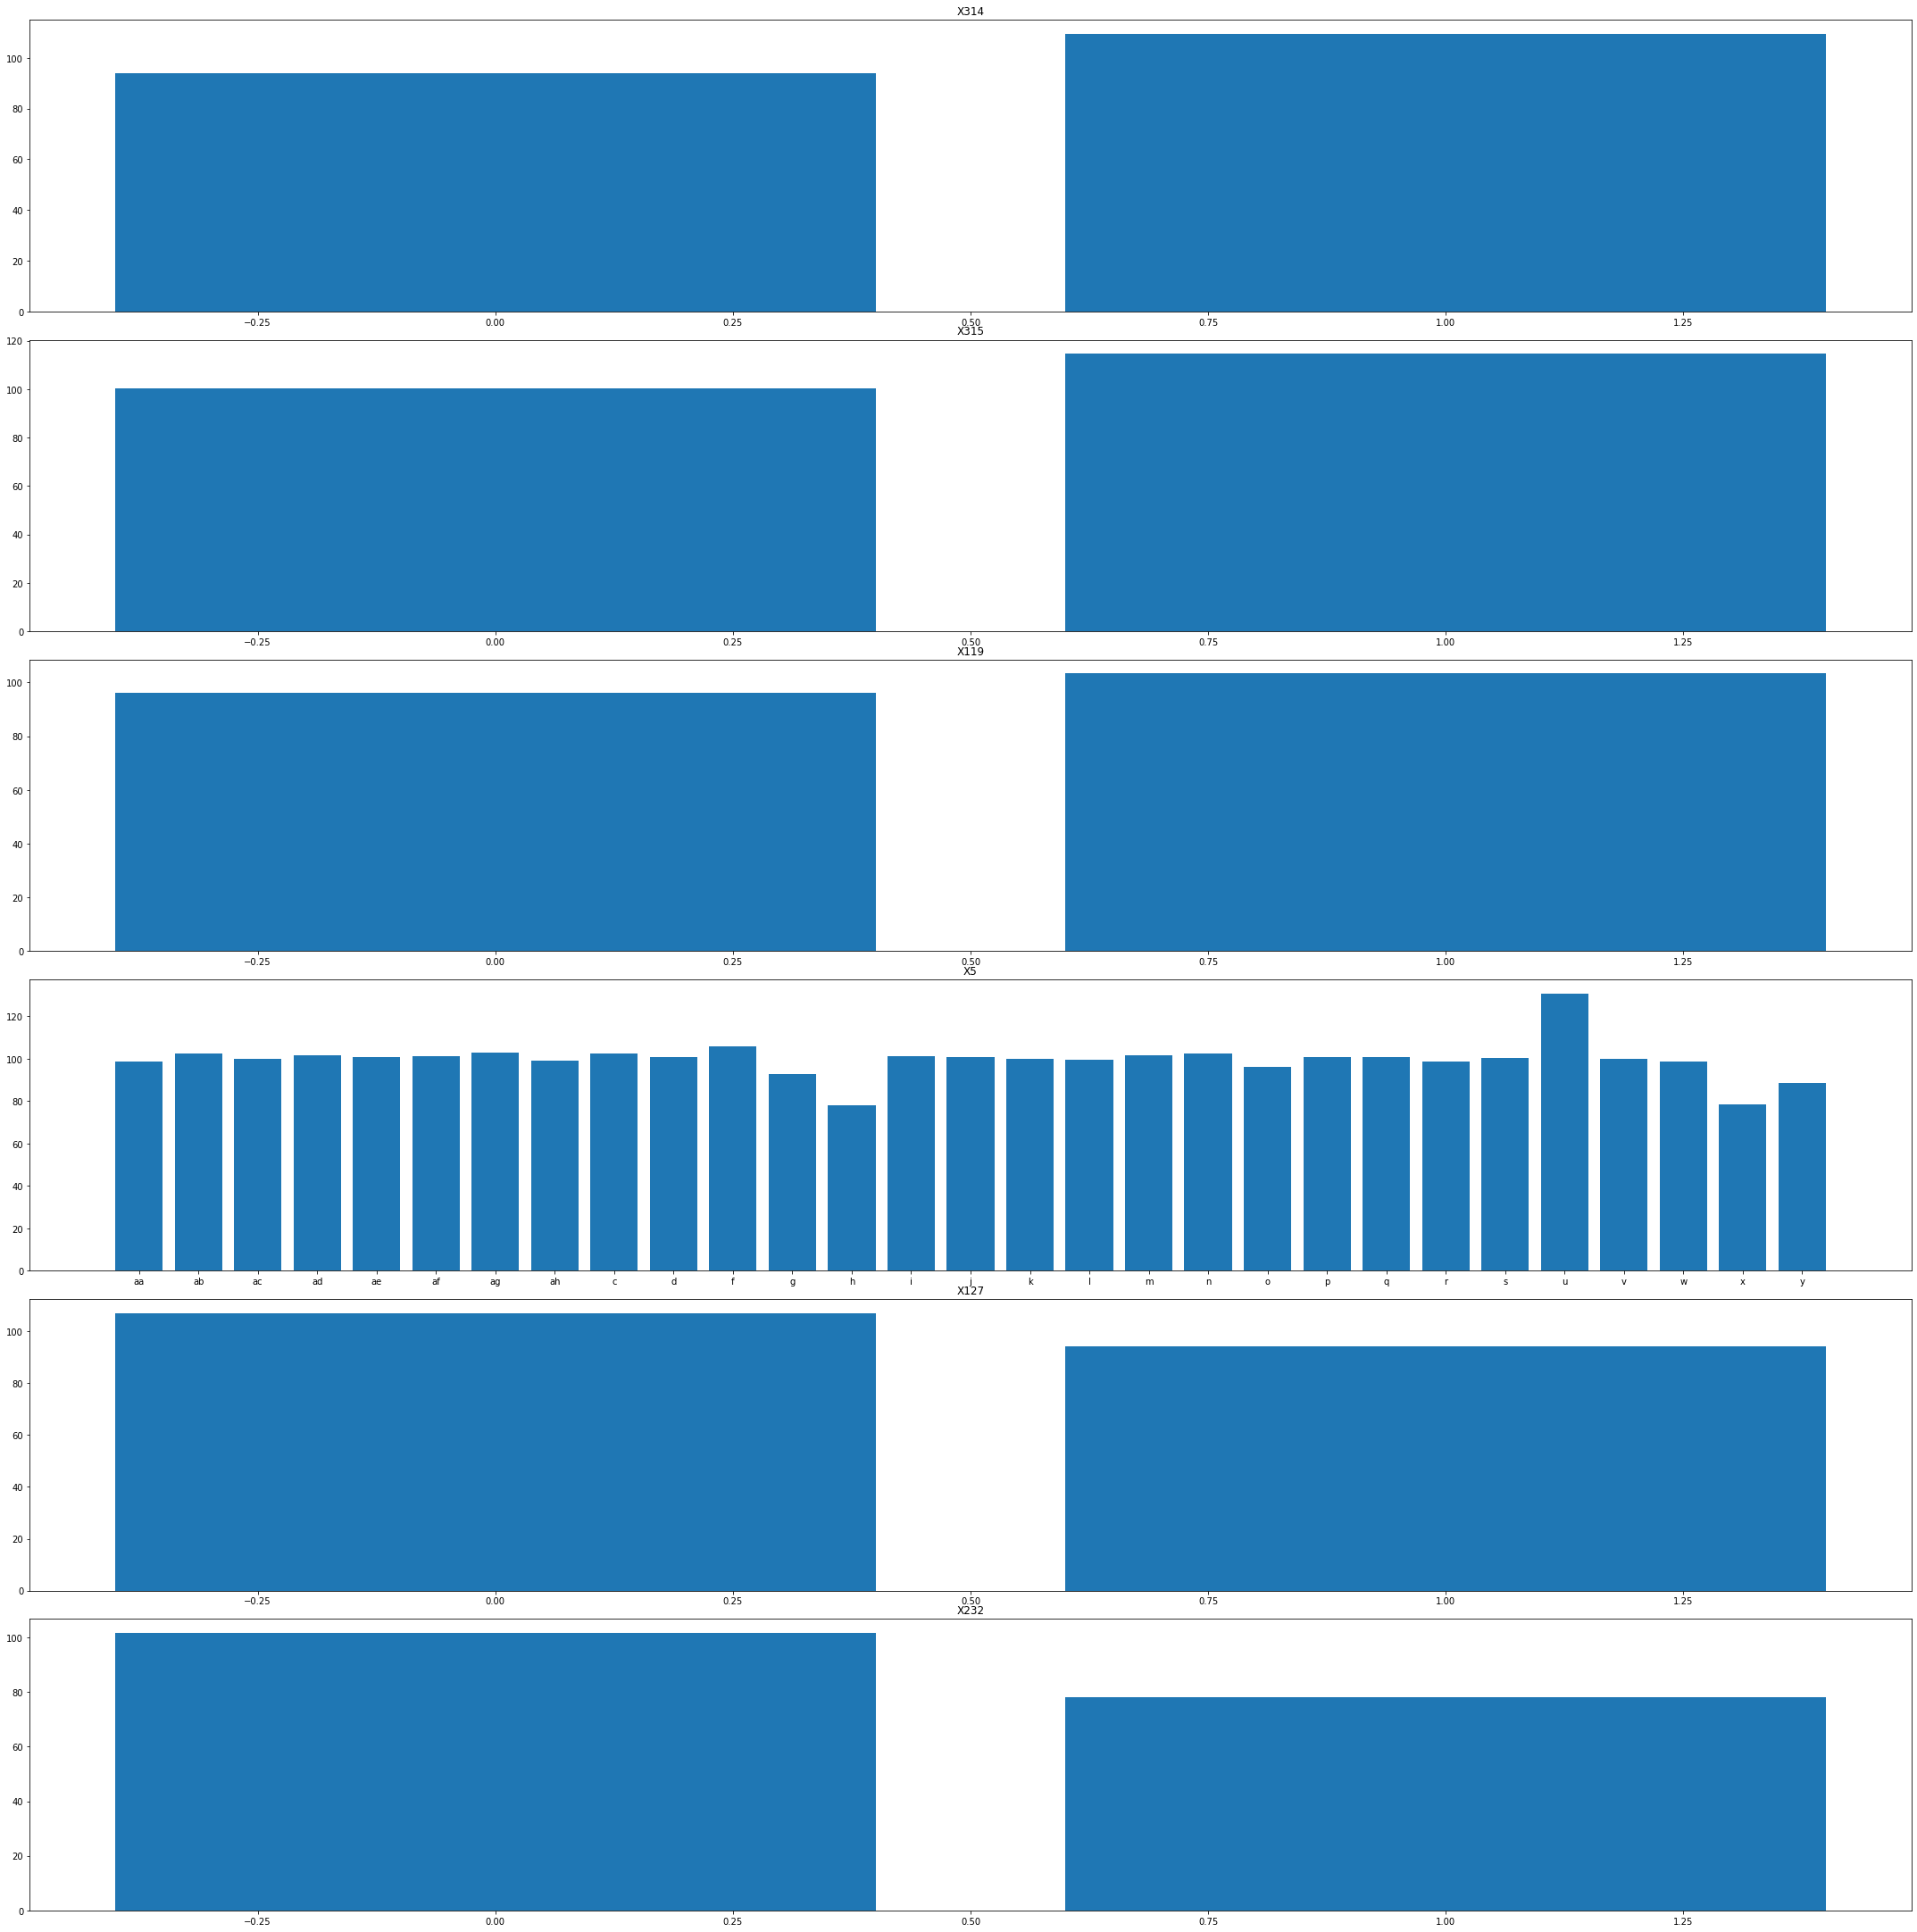

In [ ]:
fig, axs = plt.subplots(train.shape[1]-1, figsize=(30, 30))
fig.tight_layout()
for i, col in enumerate(train.columns):
  if col == dep_var: continue
  g = train_raw[[col, dep_var]].groupby(col)
  mean = g.mean()
  axs[i].bar(mean.index, mean.values.flatten())
  axs[i].set_title(col)

Text(0.5, 1.0, 'Sorted by alphabetical order')

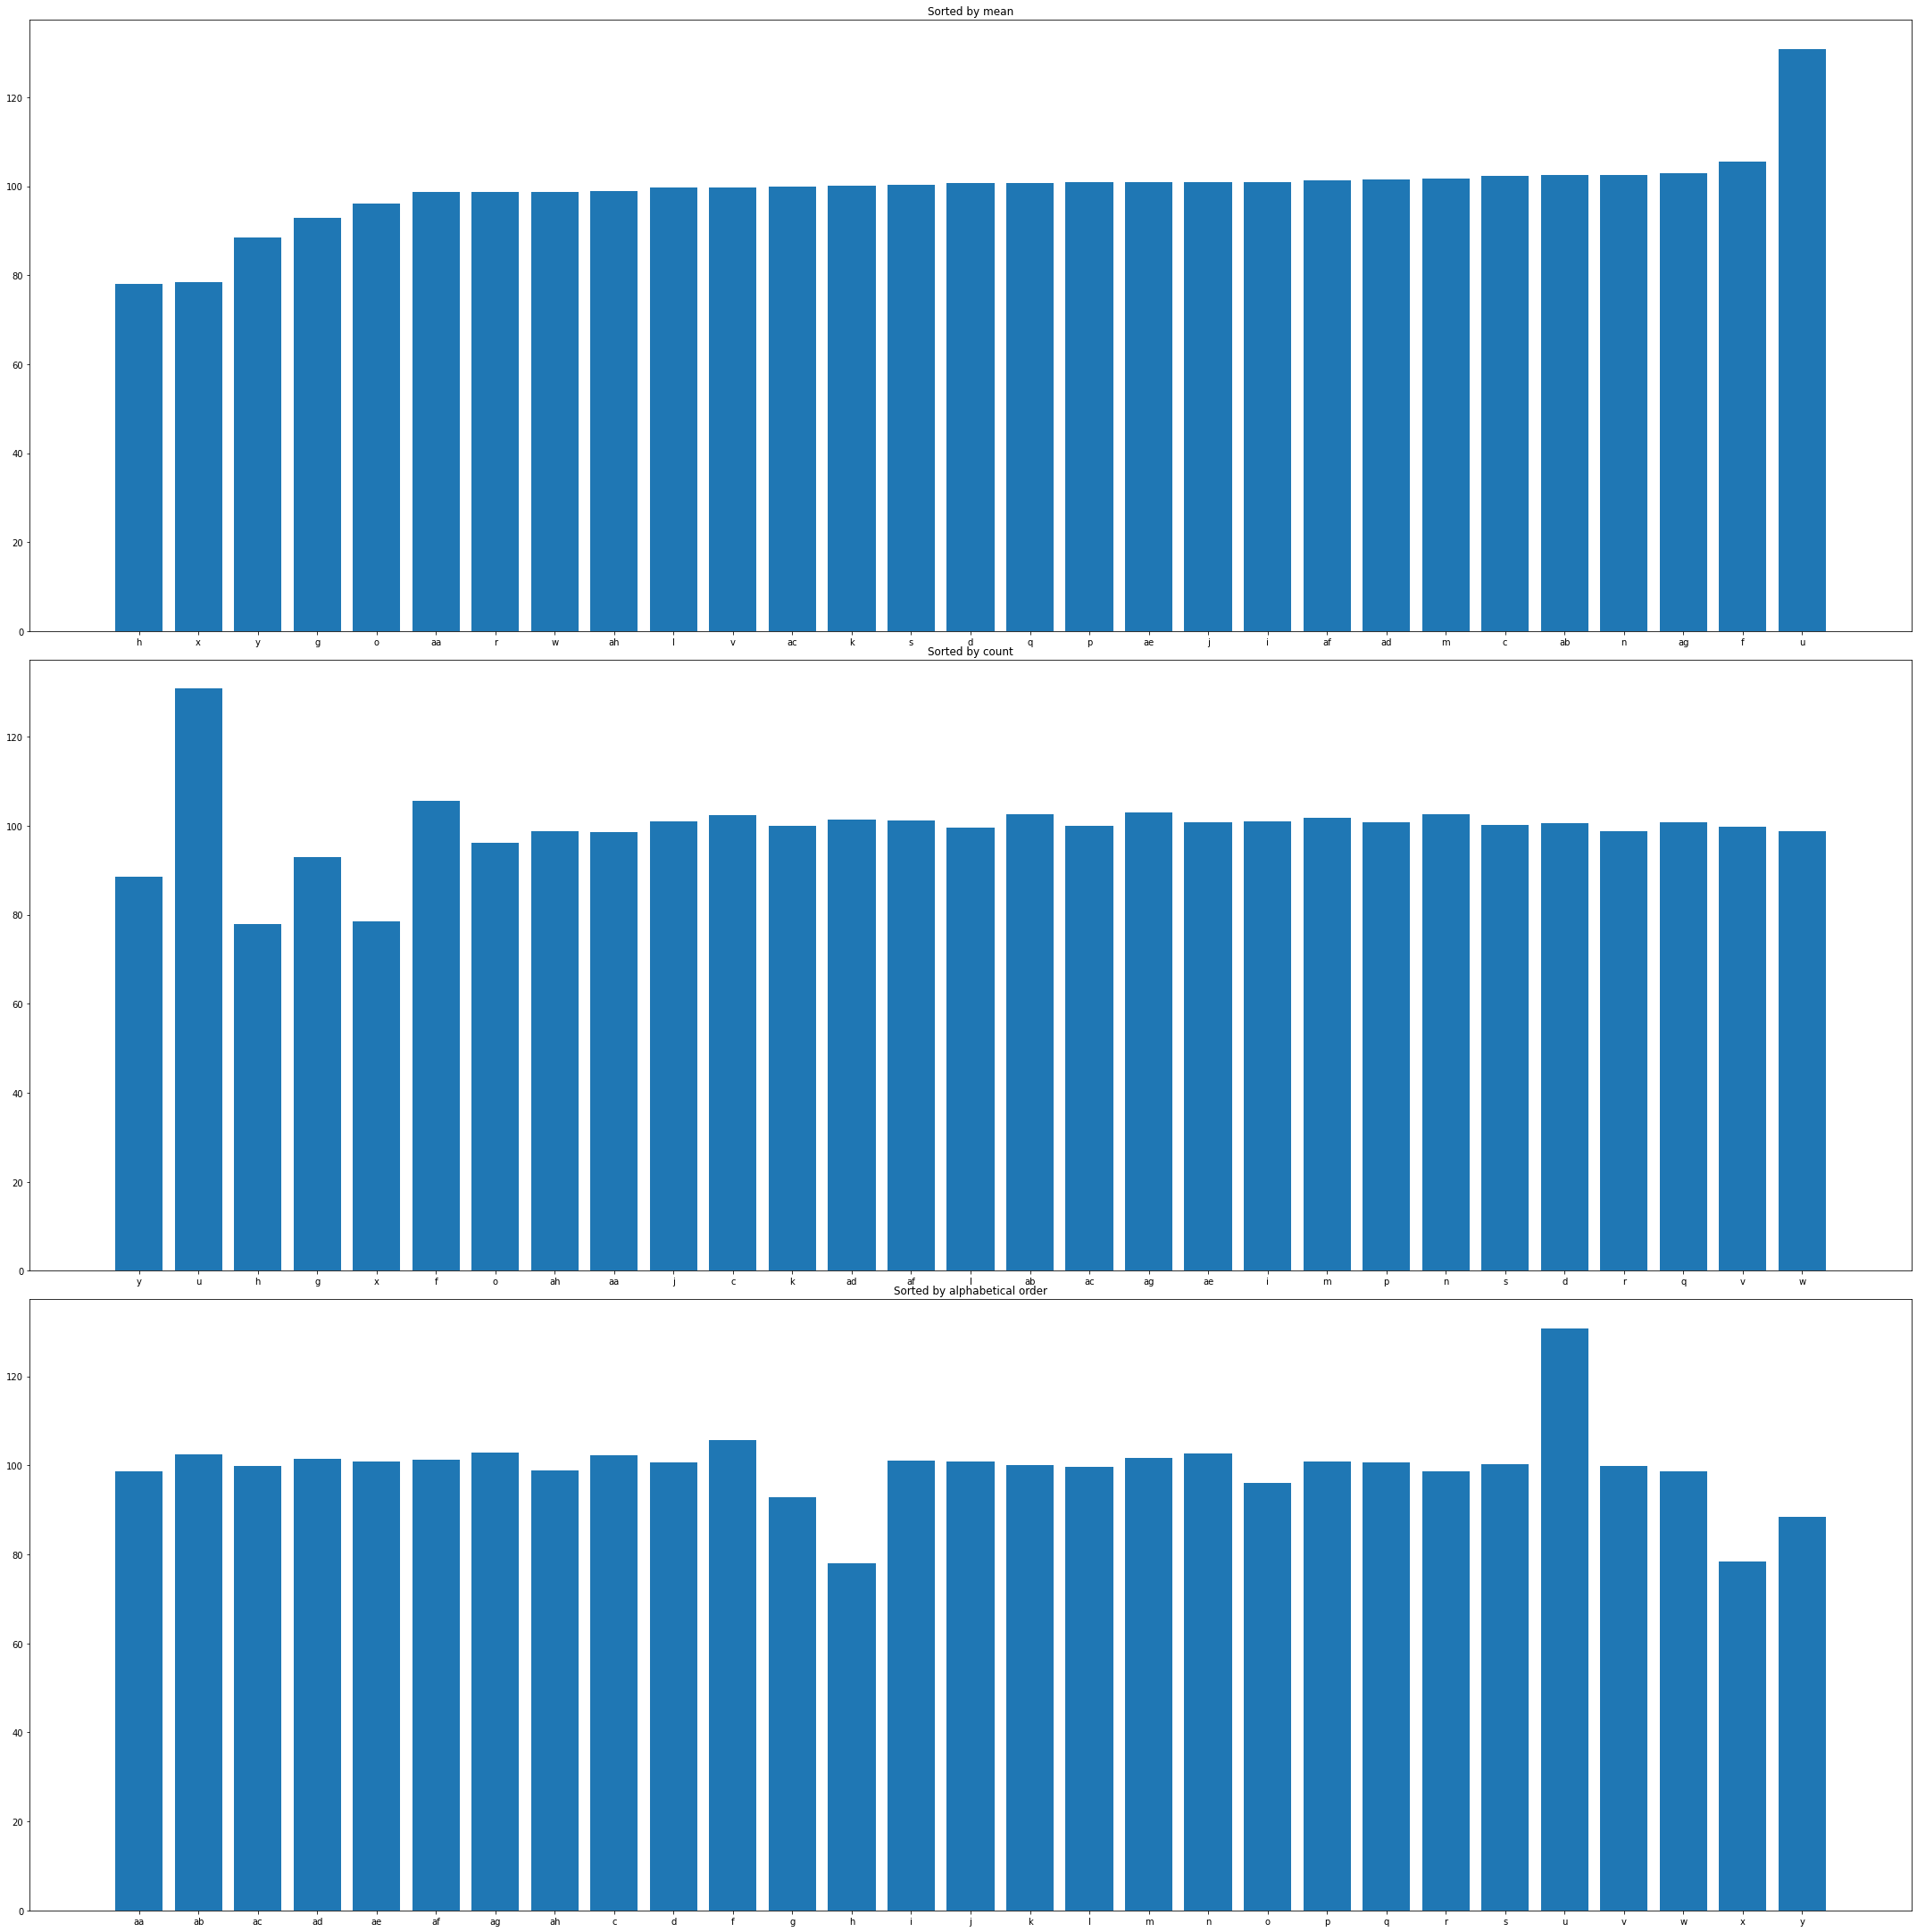

In [ ]:
fig, axs = plt.subplots(3, figsize=(30, 30))
fig.tight_layout()
g = train_raw[['X5', dep_var]].groupby('X5')
des = g.describe()
mean_sort = des.sort_values(('y', 'mean'))
count_sort = des.sort_values(('y', 'count'))
axs[0].bar(mean_sort.index, mean_sort[('y', 'mean')].values)
axs[0].set_title('Sorted by mean')
axs[1].bar(count_sort.index, count_sort[('y', 'mean')].values)
axs[1].set_title('Sorted by count')
des.sort_index(inplace=True)
axs[2].bar(des.index, des[('y', 'mean')].values)
axs[2].set_title('Sorted by alphabetical order')

In [ ]:
!pip install pdpbox

In [ ]:
from pdpbox import pdp

In [ ]:
# We need to pass in a model trained
# on our dataset to PDPbox
rf.fit(X, y)

(95.0, 105.0)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


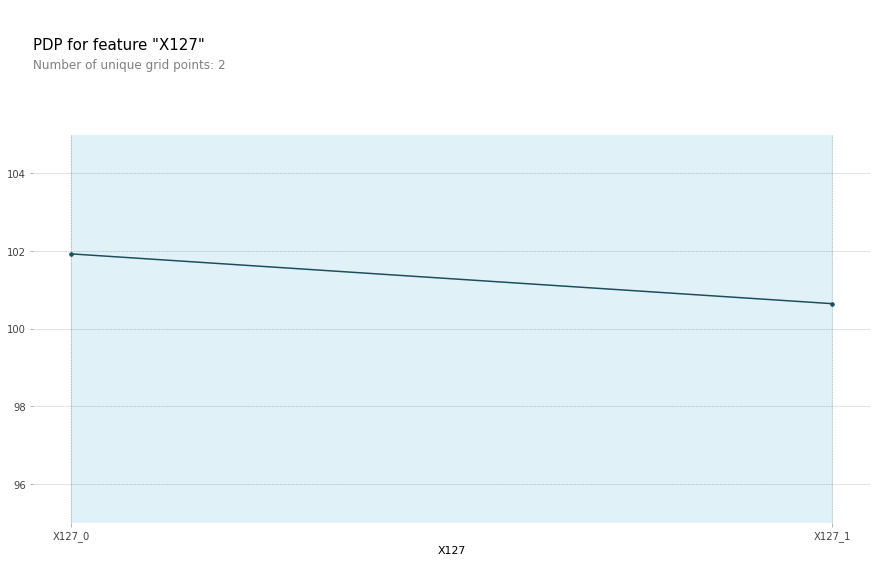

In [ ]:
# Calculate partial dependence
feat = 'X127'
pdp_isolate = pdp.pdp_isolate(rf, X, list(X), feat)
# Plot it
fig, axs = pdp.pdp_plot(pdp_isolate, feat, center=False)
# Only display the area around dependent variable = 100
axs['pdp_ax'].set_ylim([95, 105])

In [ ]:
pdp_isolate.pdp

array([101.92815283, 100.6462478 ])

In [ ]:
from collections import defaultdict

In [ ]:
raw_x5, x5 = train_raw['X5'], train['X5']
int2cat = defaultdict(lambda: 'X')
for i in range(len(train_raw)):
  int2cat[x5[i]] = raw_x5[i]

[Text(0, 0, 'aa'),
 Text(0, 0, 'ab'),
 Text(0, 0, 'ac'),
 Text(0, 0, 'ad'),
 Text(0, 0, 'ae'),
 Text(0, 0, 'af'),
 Text(0, 0, 'ag'),
 Text(0, 0, 'ah'),
 Text(0, 0, 'X'),
 Text(0, 0, 'c'),
 Text(0, 0, 'd'),
 Text(0, 0, 'f'),
 Text(0, 0, 'g'),
 Text(0, 0, 'h'),
 Text(0, 0, 'i'),
 Text(0, 0, 'j'),
 Text(0, 0, 'k'),
 Text(0, 0, 'l'),
 Text(0, 0, 'm'),
 Text(0, 0, 'n'),
 Text(0, 0, 'o'),
 Text(0, 0, 'p'),
 Text(0, 0, 'q'),
 Text(0, 0, 'r'),
 Text(0, 0, 's'),
 Text(0, 0, 'X'),
 Text(0, 0, 'u'),
 Text(0, 0, 'v'),
 Text(0, 0, 'w'),
 Text(0, 0, 'x'),
 Text(0, 0, 'y')]

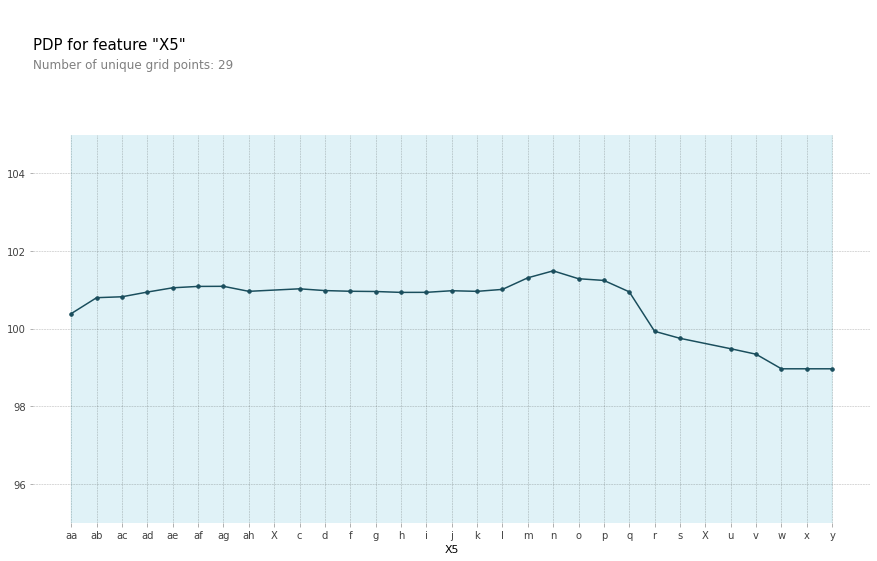

In [ ]:
feat = 'X5'
# cust_grid_point tells pdp to do partial dependence
# for every value in x5_classes, because pdp thinks
# X5 is a numerical column and so uses a slightly 
# different method, which we don't want.
x5_classes = x5.unique()
pdp_isolate = pdp.pdp_isolate(rf, X, list(X), feat,
                              cust_grid_points=x5_classes)
fig, axs = pdp.pdp_plot(pdp_isolate, feat, center=False)
axs['pdp_ax'].set_ylim([95, 105])
# The labels for the x-axis
x_ticks = [int2cat[i] for i in range(1, x5.max()+1)]
# Before we set the labels to text, 
# we must specify we'd like to see all
# x-ticks
axs['pdp_ax'].set_xticks(range(1, x5.max()+1))
# Int x-ticks to categories
axs['pdp_ax'].set_xticklabels(x_ticks)

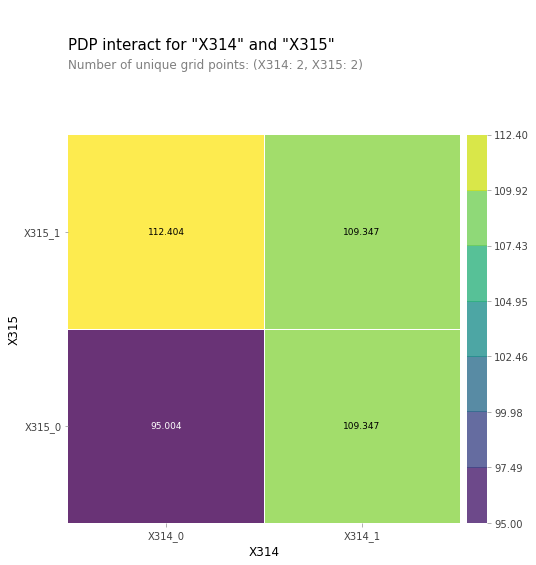

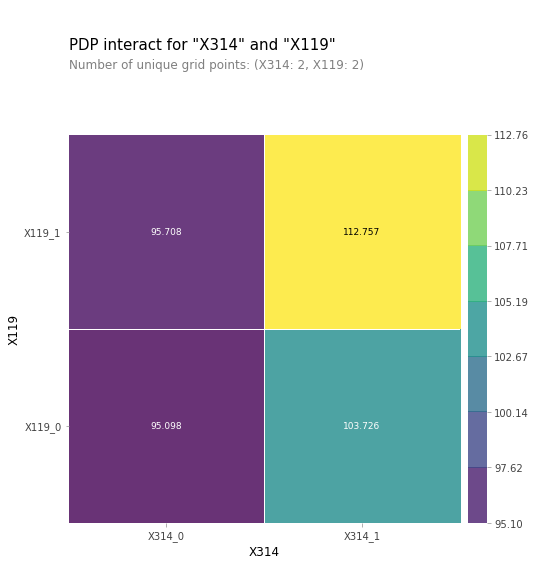

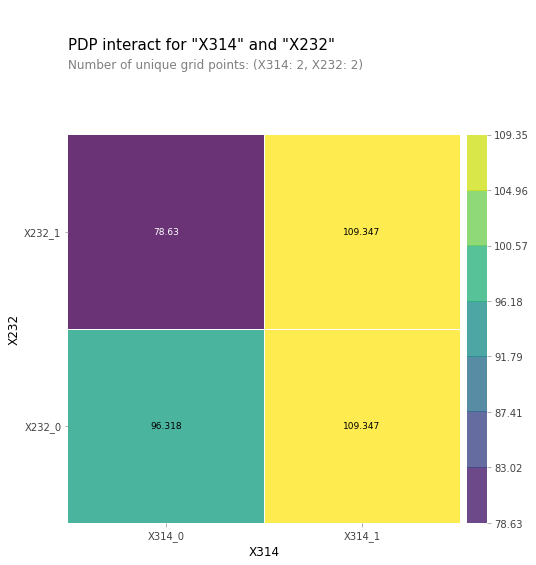

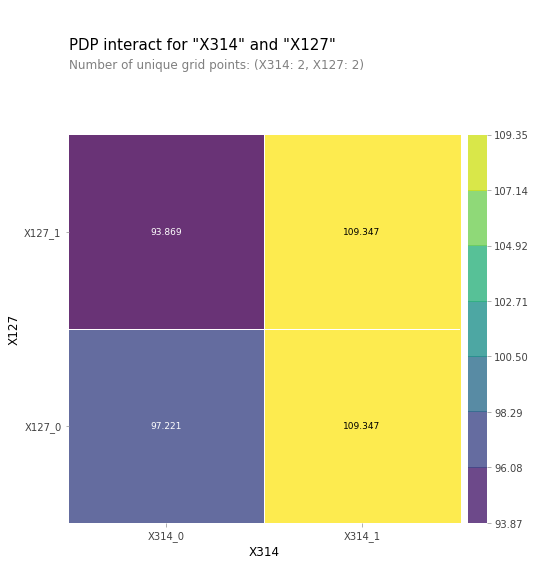

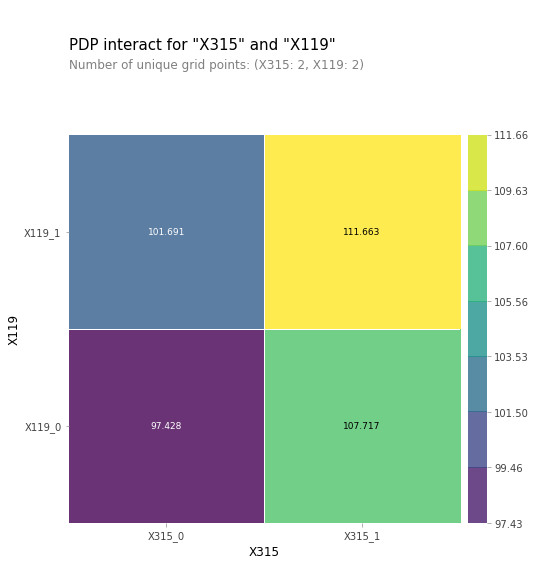

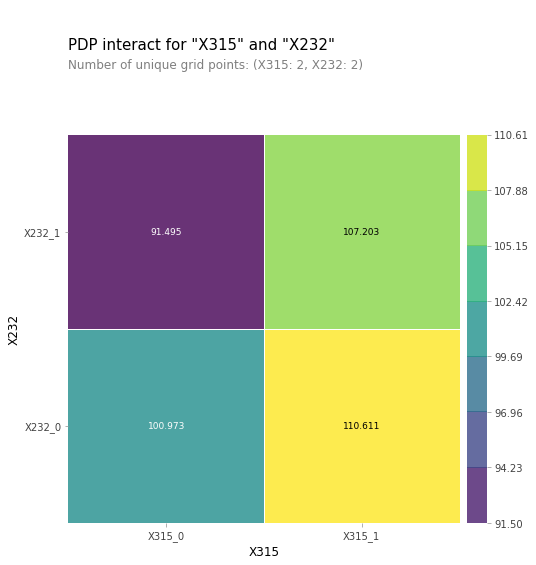

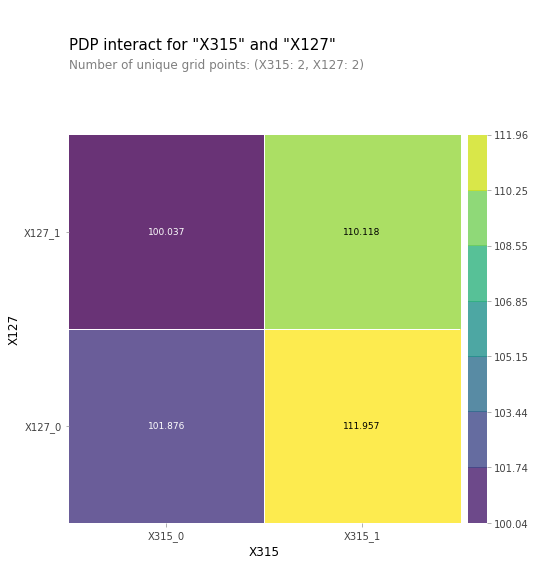

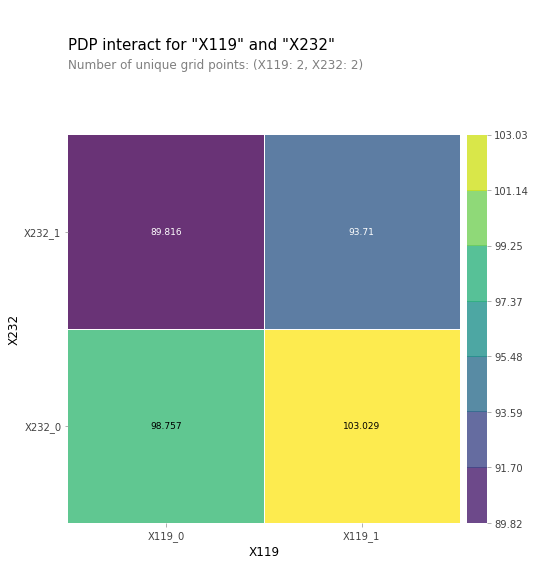

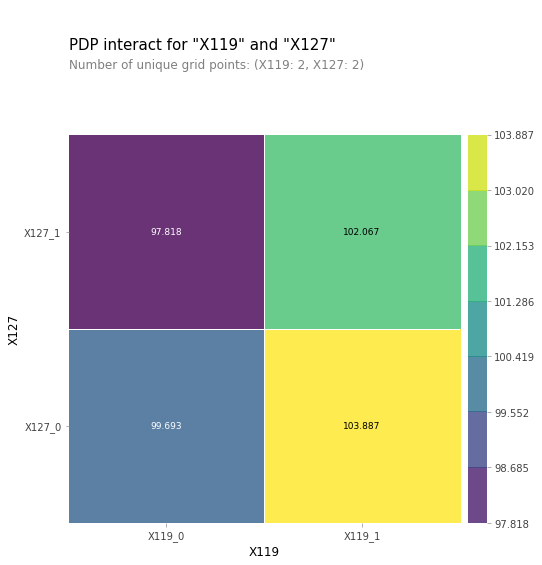

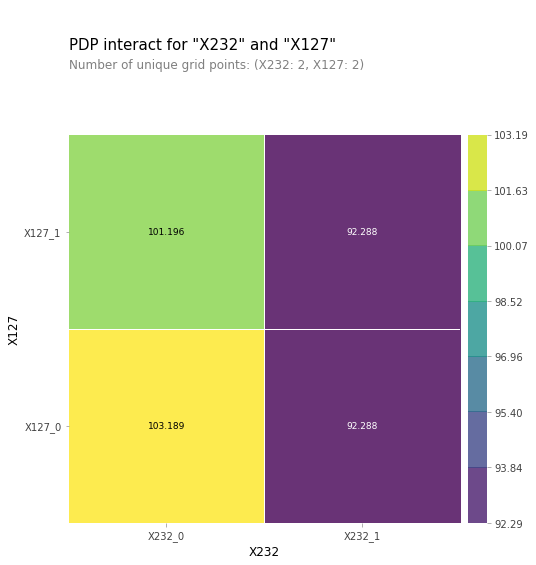

In [ ]:
cols = list(X)
# Go through all possible pairs of feature
for i in range(len(cols)-1):
  for j in range(i+1, len(cols)):
    feats = [cols[i], cols[j]]
    # Just do binary features
    if 'X5' in feats: continue
    pdp_interact = pdp.pdp_interact(rf, X, cols, feats,
                                    n_jobs=-1)
    fig, axes = pdp.pdp_interact_plot(pdp_interact, feats,
                                  plot_type='grid')

### Super Feature

In [ ]:
print_cross_val(RandomForestRegressor, train, **rf_args)

Cross validation scores: [0.56449598 0.61481091 0.45877985 0.51196641 0.63821955 0.55811029
 0.45808473 0.55970952 0.57704597 0.60405543 0.62544879 0.48122643
 0.57478026 0.57970081 0.59991391 0.6234146  0.60149983 0.60279164
 0.60258326 0.5724232  0.62773859 0.60971635 0.61753885 0.58307769
 0.59445476 0.49057858 0.47111768 0.54735838 0.65038994 0.57294181
 0.54121084 0.59671023 0.59259124 0.53247343 0.63178357 0.55926366
 0.62006203 0.5690871  0.53669978 0.56448131 0.45641898 0.60822879
 0.59635038 0.56096568 0.57855426 0.57620855 0.57162321 0.57093
 0.62080404 0.5342373  0.60375574 0.61931366 0.46682646 0.5535506
 0.46927591 0.46416671 0.62884862 0.4506768  0.56270129 0.54023981
 0.64128904 0.61445505 0.56736157 0.60533135 0.41987425 0.57354773
 0.53428213 0.48850964 0.603346   0.56417036 0.54714874 0.61781033
 0.62502664 0.49892616 0.61072206 0.60452013 0.61436433 0.53837785
 0.54451534 0.55981703 0.58888542 0.57147526 0.53860234 0.56708957
 0.59121472 0.4793418  0.57281429 0.59474

In [ ]:
for feat in X.columns:
  print(feat)
  print_cross_val(RandomForestRegressor, train.drop(feat, axis=1), **rf_args)

In [ ]:
x5 = train['X5']
train.drop('X5', axis=1, inplace=True)
X.drop('X5', axis=1, inplace=True)

In [ ]:
X.drop_duplicates()

,X314,X315,X119,X232,X127
0,0,0,1,0,0
1,0,0,1,0,1
2,0,0,0,1,0
6,0,0,0,0,1
8,1,0,1,0,0
10,1,0,0,0,0
49,0,1,1,0,0
227,0,1,0,0,0


In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
print_cross_val(DecisionTreeRegressor, train, k=2000)

In [ ]:
test = test[X.columns]
df = X.append(test)
# A Series where the ith row is 
# a tuple of the form (X[i][X314], X[i][X315], ...)
comb = df.apply(tuple, axis=1)
df['comb'] = comb
df.drop(X.columns, axis=1, inplace=True)
# Map all the tuples to an int value
df['comb'] = df['comb'].astype('category')
df['comb'] = df['comb'].cat.codes+1
train = df.iloc[:len(train)]
train[dep_var] = y
X = df.iloc[:len(train)]
test = df.iloc[len(train):]

In [ ]:
display_df(df)

,comb
0,3
1,4
2,2
3,2
4,2


,comb
4204,7
4205,4
4206,1
4207,8
4208,4


In [ ]:
df['comb'].nunique()

9

In [ ]:
df['comb'].value_counts()

4    2611
8    2401
1    1518
7    1302
2     348
6     216
5      12
3       9
9       1
Name: comb, dtype: int64

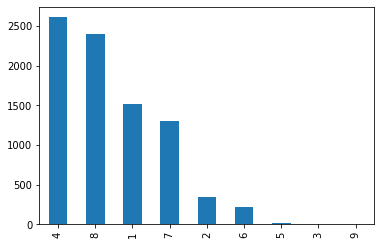

In [ ]:
df['comb'].value_counts().plot.bar()

In [ ]:
print_cross_val(DecisionTreeRegressor, train, k=2000)

### Final Model

In [ ]:
df = train_raw.drop(dep_var, axis=1).append(test_raw)
df[cat_names] = df[cat_names].astype('category')
for i in cat_names:
  df[i] = df[i].cat.codes

In [ ]:
# Loop through all the features
for col in list(df):
  # Disregard the categorical variables
  if col in cat_names: continue
  # The first if says if there are fewer than 40 ones 
  # in a feature (meaning almost the entire column is zeros),
  # then treat it as a constant column
  # But it's possible a column only has ones instead of zeros,
  # and ^1 turns zeros to ones and ones to zeros. So the second
  # if means if there are fewer than 40 zeros in a column, 
  # treat it as a constant one.
  if df[col].sum()<40 or (df[col]^1).sum()<40:
    df.drop(col, axis=1, inplace=True)

In [ ]:
to_drop = set()
# Go through every pair of features,
# starting from column[1] since column[0]
# is the dependent variable
for i in range(1, df.shape[1]-1):
  for j in range(i+1, df.shape[1]):
    # We only care about binary features
    if list(df)[i] in cat_names or list(df)[j] in cat_names:
      continue
    col1 = df.iloc[:, i]
    col2 = df.iloc[:, j]
    # The first if says if the two features are 
    # rarely the same (which means when one is zero the other 
    # is one and vice versa), then drop one. The second one means
    # if they're often the same, then drop one (~ turns falses to
    # trues and trues to falses).
    if ((col1 == col2).sum() <= 40) or (~(col1 == col2)).sum() <= 40:
      to_drop.add(list(df)[i])
df.drop(list(to_drop), axis=1, inplace=True)

In [ ]:
# 'X118' and 'X119' were duplicate,
# so let's sure only one of them remains
# ^ is  XOR (exclusive or) in Python
# It returns a 1 if and only if one of
# the inputs is true and the other one if false
('X118' in df.columns) ^ ('X119' in df.columns)

In [ ]:
display_df(df)

In [ ]:
def one_hot_encode(df, drop_first=False):
  df_one = df.copy()
  df_one.reset_index(drop=True, inplace=True)
  # Go through all the categorical features
  for cat_name in cat_names:
    # One-hot encoded version of the current column
    one_hot = pd.get_dummies(df_one[cat_name], prefix=cat_name, 
                            drop_first=drop_first).reset_index(drop=True)
    # Drop the original column and replace it with the dummy variables
    df_one.drop(cat_name, axis=1, inplace=True)
    df_one = df_one.join(one_hot)
  return df_one

In [ ]:
df_one = one_hot_encode(df)

In [ ]:
display_df(df_one)

,X10,X12,X13,X14,X18,X20,X22,X23,X26,X27,X28,X30,X37,X38,X41,X43,X45,X46,X50,X51,X55,X56,X57,X64,X68,X69,X70,X73,X75,X77,X79,X81,X82,X85,X98,X100,X101,X103,X106,X109,...,X5_30,X5_31,X5_32,X6_0,X6_1,X6_2,X6_3,X6_4,X6_5,X6_6,X6_7,X6_8,X6_9,X6_10,X6_11,X8_0,X8_1,X8_2,X8_3,X8_4,X8_5,X8_6,X8_7,X8_8,X8_9,X8_10,X8_11,X8_12,X8_13,X8_14,X8_15,X8_16,X8_17,X8_18,X8_19,X8_20,X8_21,X8_22,X8_23,X8_24
0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


,X10,X12,X13,X14,X18,X20,X22,X23,X26,X27,X28,X30,X37,X38,X41,X43,X45,X46,X50,X51,X55,X56,X57,X64,X68,X69,X70,X73,X75,X77,X79,X81,X82,X85,X98,X100,X101,X103,X106,X109,...,X5_30,X5_31,X5_32,X6_0,X6_1,X6_2,X6_3,X6_4,X6_5,X6_6,X6_7,X6_8,X6_9,X6_10,X6_11,X8_0,X8_1,X8_2,X8_3,X8_4,X8_5,X8_6,X8_7,X8_8,X8_9,X8_10,X8_11,X8_12,X8_13,X8_14,X8_15,X8_16,X8_17,X8_18,X8_19,X8_20,X8_21,X8_22,X8_23,X8_24
8413,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8414,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8415,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8416,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8417,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
X = pd.DataFrame(df[:len(train_raw)])
train = X.copy()
train[dep_var] = y
test = pd.DataFrame(df[len(train_raw):])

In [ ]:
X_one = pd.DataFrame(df_one[:len(train_raw)])
train_one = X_one.copy()
train_one[dep_var] = y
test_one = pd.DataFrame(df_one[len(train_raw):])

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

In [ ]:
print_cross_val(OrthogonalMatchingPursuit, train_one, k=1000,
                n_nonzero_coefs=40)

In [ ]:
print_cross_val(OrthogonalMatchingPursuit, train_one, k=1000,
                n_nonzero_coefs=20)

In [ ]:
orth = OrthogonalMatchingPursuit(n_nonzero_coefs=20).fit(X_one, y)
# np.where() returns the indices of nonzero elements
# orth.coef_ is just the coefficients multiplied by the features,
# so if the ith coefficient isn't zero, it means that feature 
# is being used
to_keep = list(X_one.columns[np.where(orth.coef_)[0]])
train_keep = train_one[to_keep+[dep_var]].copy()
X_keep = train_keep.drop(dep_var, axis=1)
test_keep = test_one[to_keep].copy()

In [ ]:
display_df(train_keep)

In [ ]:
def dummy_to_cat(col, df):
  dummy_names = [i for i in df.columns if i.startswith(col+'_')]
  dummies = df[dummy_names]
  # Create a Series of tuples where the ith
  # tuple is a tuple of the dummy variables
  # in row i
  cat = dummies.apply(tuple, axis=1)
  # Label encoding (tuples >- ints)
  cat = cat.astype('category').cat.codes
  df.drop(dummy_names, axis=1, inplace=True)
  df[col] = cat
  return df

In [ ]:
df = train_keep.drop(dep_var, axis=1).append(test_keep)
# Doing this to 'X2's dummy variables isn't 
# needed, since there's only 1 such variable
for col in ['X0', 'X2', 'X5']:
  df = dummy_to_cat(col, df)
X_keep = df[:len(train_raw)]
train_keep = X_keep.copy()
train_keep[dep_var] = y
test_keep = df[len(train_raw):]

In [ ]:
display_df(df)

In [ ]:
rf_cross_val = partial(print_cross_val, RandomForestRegressor,
                       train_keep, n_jobs=-1, n_estimators=40)

In [ ]:
rf_cross_val()

In [ ]:
rf_cross_val(min_samples_leaf=3)

In [ ]:
rf_cross_val(min_samples_leaf=5)

In [ ]:
rf_cross_val(min_samples_leaf=10)

In [ ]:
rf_cross_val(min_samples_leaf=5, max_features=0.5)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
train_keep = train_keep.join(train_id)
X_keep = X_keep.join(train_id)
test_keep.reset_index(drop=True, inplace=True)
test_keep = test_keep.join(test_id)

In [ ]:
# Good initial parameters
lgbm_cross_val = partial(print_cross_val, LGBMRegressor, train_keep, k=1000,
                         n_jobs=-1, n_estimators=400, learning_rate=0.01,
                         max_depth=3, min_child_samples=1)

In [ ]:
lgbm_cross_val()

In [ ]:
lgbm_cross_val(max_depth=4)

In [ ]:
lgbm_cross_val(learning_rate=0.03)

In [ ]:
lgbm_cross_val(min_child_samples=3)

In [ ]:
lgbm_cross_val(min_child_samples=5)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_cross_val = partial(print_cross_val, XGBRegressor, train_keep, k=200, silent=True,
                        n_jobs=-1, n_estimators=400, max_depth=3, learning_rate=0.01, 
                        colsample_bytree=1)

In [ ]:
xgb_cross_val()

In [ ]:
xgb_cross_val(max_depth=4)

In [ ]:
xgb_cross_val(max_depth=5)

In [ ]:
xgb_cross_val(max_depth=4, learning_rate=0.03)

In [ ]:
xgb_cross_val(max_depth=4, learning_rate=0.1)

In [ ]:
xgb_cross_val(max_depth=4, learning_rate=0.03, colsample_bytree=0.5)

In [ ]:
xgb_cross_val(max_depth=4, learning_rate=0.03, colsample_bytree=0.3)

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
lgbm = LGBMRegressor(n_jobs=-1, n_estimators=400, learning_rate=0.01,
                     max_depth=3, min_child_samples=3)
xgb = XGBRegressor(silent=True,
                   n_jobs=-1, n_estimators=400, max_depth=4, learning_rate=0.03, 
                   colsample_bytree=0.5)
estimators = [('lgbm', lgbm),
              ('xgb', xgb)]

In [ ]:
ens_cross_val = partial(print_cross_val, VotingRegressor, train_keep,
                        estimators=estimators, n_jobs=-1)

In [ ]:
ens_cross_val(weights=[0.9, 0.1])

In [ ]:
ens_cross_val(weights=[0.7, 0.3])

In [ ]:
ens = VotingRegressor(estimators, n_jobs=-1,
                      weights=[0.9, 0.1]).fit(X_keep, y)

In [ ]:
test_pred = ens.predict(test_keep)
test_pred = pd.DataFrame({'ID': test_id,
                          dep_var: test_pred})
test_pred.to_csv('submission.csv', index=False)

In [ ]:
# Submit to Kaggle
!kaggle competitions submit -c mercedes-benz-greener-manufacturing -f submission.csv -m ""

100% 95.2k/95.2k [00:02<00:00, 39.5kB/s]
Successfully submitted to Mercedes-Benz Greener Manufacturing